# Chapter 2.2 — Causal Attention: Why GPT Doesn’t Peek Ahead

Companion Medium Article: https://medium.com/@vadidsadikshaikh/chapter-2-2-causal-attention-why-gpt-doesnt-peek-ahead-7172f8e98426

This notebook demonstrates **causal (masked) self-attention**, which ensures that autoregressive models such as GPT generate tokens sequentially without looking at future positions.

Reference: Vaswani et al., *Attention Is All You Need* (2017) and Sebastian Raschka, *Build a Large Language Model (From Scratch)*, Chapter 6.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)

## 1. Setup — Input Embeddings

We use a small batch of dummy embeddings to simulate tokens in a sequence. Each token will only attend to previous ones and itself.

In [2]:
batch_size = 1
seq_len = 4
d_model = 4

x = torch.randn(batch_size, seq_len, d_model)
x

tensor([[[-1.1258, -1.1524, -0.2506, -0.4339],
         [ 0.8487,  0.6920, -0.3160, -2.1152],
         [ 0.3223, -1.2633,  0.3500,  0.3081],
         [ 0.1198,  1.2377,  1.1168, -0.2473]]])

## 2. Linear Projections for Queries, Keys, and Values

In [3]:
W_Q = torch.nn.Linear(d_model, d_model, bias=False)
W_K = torch.nn.Linear(d_model, d_model, bias=False)
W_V = torch.nn.Linear(d_model, d_model, bias=False)

Q = W_Q(x)
K = W_K(x)
V = W_V(x)

Q.shape, K.shape, V.shape

(torch.Size([1, 4, 4]), torch.Size([1, 4, 4]), torch.Size([1, 4, 4]))

## 3. Create the Causal Mask

A causal mask ensures that each token can only attend to itself and the tokens that came before it. Future tokens are masked (set to negative infinity).

In [4]:
mask = torch.tril(torch.ones(seq_len, seq_len))  # lower-triangular matrix
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

## 4. Apply Masked Scaled Dot-Product Attention

We compute attention scores and apply the mask before softmax. Positions corresponding to future tokens are set to `-inf` so their weights become zero after the softmax step.

In [5]:
d_k = K.size(-1)
scores = torch.matmul(Q, K.transpose(-2, -1)) / d_k**0.5

# Apply mask: set future token scores to -inf
scores = scores.masked_fill(mask == 0, float('-inf'))

attn = F.softmax(scores, dim=-1)
output = torch.matmul(attn, V)

print('Attention weights (masked):\n', attn)
print('\nOutput representations:\n', output)

Attention weights (masked):
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2526, 0.7474, 0.0000, 0.0000],
         [0.3018, 0.2972, 0.4011, 0.0000],
         [0.2149, 0.3615, 0.1914, 0.2321]]], grad_fn=<SoftmaxBackward0>)

Output representations:
 tensor([[[-0.0254, -0.2575,  0.5407, -0.4777],
         [-1.0177,  0.4820,  0.4854, -0.0420],
         [-0.3229,  0.1419,  0.4297, -0.2084],
         [-0.4102,  0.3390,  0.1622, -0.1316]]], grad_fn=<UnsafeViewBackward0>)


## 5. Visualize Mask and Attention Weights

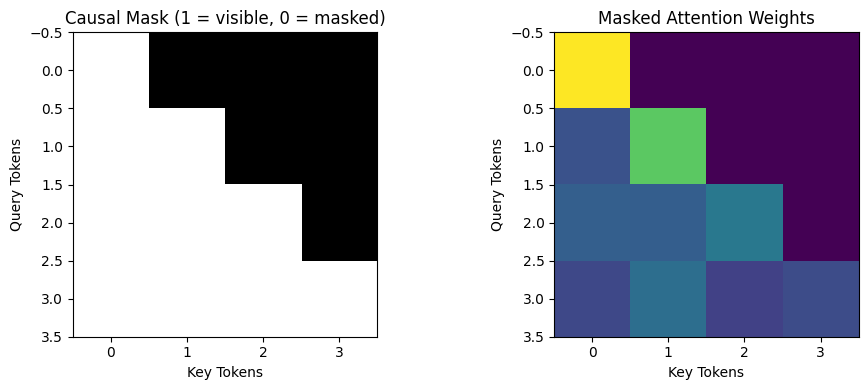

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Mask visualization
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Causal Mask (1 = visible, 0 = masked)')
axes[0].set_xlabel('Key Tokens')
axes[0].set_ylabel('Query Tokens')

# Attention heatmap
axes[1].imshow(attn[0].detach(), cmap='viridis')
axes[1].set_title('Masked Attention Weights')
axes[1].set_xlabel('Key Tokens')
axes[1].set_ylabel('Query Tokens')

plt.tight_layout()
plt.show()

## 6. Interpretation

- The **mask** hides future tokens by setting their scores to negative infinity.
- In the **attention heatmap**, upper-triangular areas are zero — no token attends to future ones.
- Each token builds its context using only current and previous tokens.

This ensures autoregressive behavior: GPT-like models generate one token at a time, maintaining causality.

### References
- Vaswani et al., *Attention Is All You Need* (2017)
- Sebastian Raschka, *Build a Large Language Model (From Scratch)*, Chapter 6